# FINAL TILDA statistical analysis script

In [1]:
#from pynm.pynm import PyNM
import seaborn as sns
#import matplotx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels import graphics
from statsmodels.graphics.api import abline_plot
from sklearn.linear_model import LinearRegression
import os, csv
from pathlib import Path
import pandas as pd
import nibabel as nib
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import nilearn.plotting
from IPython.display import display, clear_output
from ipywidgets import widgets, interact
import numpy as np
import regtricks as rt
from nibabel import nifti1
from PIL import Image
from nibabel.viewers import OrthoSlicer3D
from nilearn import datasets, surface

%matplotlib widget


# TILDA charactertics

In [36]:
TILDA_stats_path = os.path.join(r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results', 'MC_Initial_TILDA_vars_081021.xls')
tilda_df = pd.read_excel(TILDA_stats_path)
tilda_df

,MRN,Scan_date,age_W3,sex_W3,edu3_W3,MDmeds4_W3,MDmeds_W3,MDmeds_excl_supps_W3,MDmeds4_excl_supps_W3,MDpolypharmacy_W3,...,COGimmediaterecall2_W3,COGmmse_W3,COGdelayedrecall_W4,COGimmediaterecall1_W4,COGimmediaterecall2_W4,COGmmse_W4,COGdelayedrecall_W5,COGimmediaterecall1_W5,COGimmediaterecall2_W5,COGmmse_W5
0,1271791,20150326,68,1,3,1,1,1,1,0,...,7,28.0,5.0,5.0,7.0,29.0,10.0,8.0,10.0,30.0
1,1299293,20150910,68,2,1,2,4,4,2,0,...,6,30.0,7.0,6.0,9.0,29.0,4.0,6.0,7.0,27.0
2,1313597,20151127,69,2,1,0,0,0,0,0,...,9,29.0,8.0,5.0,9.0,29.0,NaN,NaN,NaN,NaN
3,1327634,20160219,64,2,2,0,0,0,0,0,...,10,27.0,10.0,10.0,10.0,29.0,7.0,8.0,7.0,29.0
4,1304325,20151009,72,1,2,1,2,1,1,0,...,6,30.0,4.0,4.0,7.0,27.0,5.0,5.0,7.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,1310804,20151113,68,2,2,3,6,6,3,1,...,10,27.0,8.0,6.0,8.0,30.0,9.0,8.0,10.0,30.0
554,1310808,20151113,71,1,2,3,8,8,3,1,...,8,29.0,4.0,5.0,5.0,27.0,3.0,3.0,6.0,28.0
555,1315904,20151210,74,1,3,3,7,6,3,1,...,5,25.0,0.0,5.0,6.0,27.0,0.0,3.0,5.0,25.0
556,1276406,20150423,73,2,2,3,6,6,3,1,...,7,28.0,5.0,3.0,7.0,29.0,5.0,4.0,5.0,28.0


# Volumetric resutls

In [2]:
vol_data_path = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\oxasl_vol'
pvc_vol_data_path =  os.path.join(vol_data_path, 'pvc')
nonpvc_vol_data_path =  os.path.join(vol_data_path, 'nonpvc')
nonpvc_50gm_vol_data_path =  os.path.join(vol_data_path, 'nonpvc_50pv')
vol_save_path = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\vol_results'
outlier_path = r"D:\onedrive\OneDrive - The University of Nottingham\TILDA\Documentation\Exclusions\TILDA_ASL_Exclusions_1_10_21.xls"

### Exclusion criteria

In [7]:
outlier_pd = pd.read_excel(outlier_path)
vars_pd = pd.read_excel(TILDA_stats_path)

artefact_subjects = outlier_pd[outlier_pd['exclude_CBF']==1]['MRN'].to_list()#34
parkison_subjects = vars_pd[vars_pd['CHRparkinsons_W3']==1]['MRN'].to_list()#1
mmse_subjects = vars_pd[vars_pd['COGmmse_W3']<24]['MRN'].to_list()#5
age1_subjects = vars_pd[vars_pd['age_W3']<54]['MRN'].to_list()#10
age2_subjects = vars_pd[vars_pd['age_W3']>84]['MRN'].to_list()#8

subjects_exclusion_list = []
subjects_exclusion_list = artefact_subjects+ parkison_subjects + mmse_subjects + age1_subjects + age2_subjects
subjects_exclusion_list = list(set(subjects_exclusion_list))#58

### Calculate Mean GM CBF

In [59]:
nonpvc_gm_list = []
nonpvc_50pv_gm_list = []
pvc_gm_list = []
subj_white_list = []

# read gm cbf from oxasl results for non-pvc data
for stat in os.listdir(nonpvc_vol_data_path):
    stat_path = os.path.join(nonpvc_vol_data_path, stat)
    subid = int(stat[-11:-4])
    df = pd.read_csv(stat_path)
    gm_perf = df.iloc[2,2]
    if gm_perf < 10: continue
    if gm_perf > 100: continue
    if subid in subjects_exclusion_list: continue
    subj_white_list.append(subid)
    nonpvc_gm_list.append([subid, gm_perf])

for stat in os.listdir(nonpvc_50gm_vol_data_path):
    stat_path = os.path.join(nonpvc_50gm_vol_data_path, stat)
    subid = int(stat[-11:-4])
    df = pd.read_csv(stat_path)
    gm_perf = df.iloc[3,2]
    if gm_perf < 10: continue
    if gm_perf > 100: continue
    if subid in subjects_exclusion_list: continue
    #subj_white_list.append(subid)
    #print(subid)
    nonpvc_50pv_gm_list.append([subid, gm_perf])

    
# read gm cbf from oxasl results for pvc data
for stat in os.listdir(pvc_vol_data_path):
    if 'gm' not in stat: continue
    stat_path = os.path.join(pvc_vol_data_path, stat)
    subid = int(stat[-11:-4])
    df = pd.read_csv(stat_path)
    gm_perf = df.iloc[2,2]
    if gm_perf < 10: continue
    if subid in subjects_exclusion_list: continue
    pvc_gm_list.append([subid, gm_perf])
    
nonpvc_gm_list = np.array(nonpvc_gm_list)
nonpvc_gm_perf_df = pd.DataFrame(nonpvc_gm_list, columns=['subject', 'gm_voxel_nonpvc'])
nonpvc_gm_perf_df.set_index(['subject'], inplace=True)
nonpvc_gm_perf_df.round(2)
print("Non-PVC GM CBF: ", round(nonpvc_gm_perf_df['gm_voxel_nonpvc'].mean(), 2))
print(nonpvc_gm_perf_df['gm_voxel_nonpvc'].std())

nonpvc_50pv_gm_list = np.array(nonpvc_50pv_gm_list)
nonpvc_50pv_gm_perf_df = pd.DataFrame(nonpvc_50pv_gm_list, columns=['subject', 'gm_voxel_nonpvc'])
nonpvc_50pv_gm_perf_df.set_index(['subject'], inplace=True)
nonpvc_50pv_gm_perf_df.round(2)
print("Non-PVC 50PV GM CBF: ", round(nonpvc_50pv_gm_perf_df['gm_voxel_nonpvc'].mean(), 2))
print(nonpvc_50pv_gm_perf_df['gm_voxel_nonpvc'].std())

pvc_gm_list = np.array(pvc_gm_list)
pvc_gm_perf_df = pd.DataFrame(pvc_gm_list, columns=['subject', 'gm_voxel_pvc']).round(2)
pvc_gm_perf_df.set_index(['subject'], inplace=True)
pvc_gm_perf_df.round(2)
print("PVC GM CBF: ", round(pvc_gm_perf_df['gm_voxel_pvc'].mean(), 2))
print(pvc_gm_perf_df['gm_voxel_pvc'].std())




Non-PVC GM CBF:  40.66
8.53409320804373
Non-PVC 50PV GM CBF:  42.98
8.59669730275845
PVC GM CBF:  48.56
9.779256408770802


### Calculating regional GM CBF

In [61]:
vol_work_dir = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\oxasl_vol'
vol_save_dir = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\vol_results'


#for ipvc in ['nonpvc', 'pvc', 'nonpvc_50pv']:
for ipvc in ['nonpvc_50pv']:
    vol_dict = {}
    stat_list = os.listdir(os.path.join(vol_work_dir, ipvc))
    for stat in stat_list:
        if ipvc == 'pvc' and 'gm' not in stat: continue
        stat_path = os.path.join(vol_work_dir, ipvc, stat)
        subid = int(stat[-11:-4])
        if subid in subjects_exclusion_list: continue
        df = pd.read_csv(stat_path)
        #read all rois to vol_dict
        for index, row in df.iterrows():
            if row.iloc[0] not in vol_dict:
                vol_dict[row.iloc[0]] = []
            vol_dict[row.iloc[0]].append([subid, row.iloc[2]])

        # replace column names and add age, sex, and subject columns for each roi
    for roi in vol_dict.keys():
        roi_df = pd.DataFrame(vol_dict[roi], columns=['subject', 'gm'])
        roi_df = pd.merge(tilda_df, roi_df, left_on='MRN', right_on='subject')
        roi_df = roi_df[['MRN', 'age_W3', 'sex_W3', 'gm']]
        roi_df.rename(columns={'age_W3':'age', 'sex_W3':'sex', 'MRN':'subject'}, inplace=True)
        roi_df.to_csv(os.path.join(vol_save_dir, ipvc, roi+'.csv'))
            

### regressions on ROIs

In [62]:
#work_path = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\vol_results'
vol_roi_output_dir = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\vol_results'

#for ipvc in ['nonpvc', 'pvc', 'nonpvc_50pv']:
for ipvc in [  'nonpvc_50pv']:
    rois_dict = []
    stat_list = os.listdir(os.path.join(vol_roi_output_dir, ipvc))
    
    for stat in stat_list:
        try:
            
            roi_df = pd.read_csv(os.path.join(vol_roi_output_dir, ipvc, stat))
            
            #roi_df.dropna(axis=0, how='any')
            roi_df = roi_df[roi_df['gm'] > 0]
            X = np.column_stack((roi_df['age'], roi_df['sex']))
            Y = roi_df['gm']
            x = sm.add_constant(X)
            reg = sm.OLS(Y, x).fit()

            pred = reg.predict(x)[0]

            if stat[0] == 'b':
                rois_dict.append({'roi':stat[2:-5], 'a':reg.params['x1'], 'b':reg.params['x2'], 'gm': np.mean(Y), 'std': np.std(Y), 'pred':pred, 'p':reg.pvalues['x1']})
            else:
                #if np.isnan(reg.params['x1']): continue
                rois_dict.append({'roi':stat[0:-4], 'a':reg.params['x1'], 'b':reg.params['x2'], 'gm': np.mean(Y), 'std': np.std(Y),  'pred':pred, 'p':reg.pvalues['x1']})
        except Exception as e:
            pass
            #print(os.path.join(vol_roi_output_dir, ipvc, stat))
            #print(e)

    
    rois_df = pd.DataFrame.from_dict(rois_dict)
    rois_df['a'] =rois_df['a'].round(2)
    rois_df['b'] =rois_df['b'].round(2)
    rois_df['gm'] =rois_df['gm'].round(2)
    rois_df['p'] =rois_df['p'].round(4)
    rois_df.to_csv(os.path.join(vol_roi_output_dir, 'subcort_' + ipvc +'_rois_reg.csv'))
        

In [69]:
nonpvc_tilda_df = pd.merge(tilda_df, nonpvc_gm_perf_df, left_on='MRN', right_on='subject')
nonpvc_tilda_df = nonpvc_tilda_df[['MRN', 'age_W3', 'sex_W3', 'gm_voxel_nonpvc']]
nonpvc_tilda_df.rename(columns={'age_W3':'age', 'sex_W3':'sex', 'MRN':'subject'}, inplace=True)
nonpvc_tilda_df.to_csv(os.path.join(vol_save_path, 'voxelwise_nonpvc_stats.csv'))

In [70]:
nonpvc_50pv_tilda_df = pd.merge(tilda_df, nonpvc_50pv_gm_perf_df, left_on='MRN', right_on='subject')
nonpvc_50pv_tilda_df = nonpvc_50pv_tilda_df[['MRN', 'age_W3', 'sex_W3', 'gm_voxel_nonpvc']]
nonpvc_50pv_tilda_df.rename(columns={'age_W3':'age', 'sex_W3':'sex', 'MRN':'subject'}, inplace=True)
nonpvc_50pv_tilda_df.to_csv(os.path.join(vol_save_path, 'voxelwise_nonpvc_50pv_stats.csv'))

In [17]:
pvc_tilda_df = pd.merge(tilda_df, pvc_gm_perf_df, left_on='MRN', right_on='subject')
pvc_tilda_df = pvc_tilda_df[['MRN', 'age_W3', 'sex_W3', 'gm_voxel_pvc']]
pvc_tilda_df.rename(columns={'age_W3':'age', 'sex_W3':'sex', 'MRN':'subject'}, inplace=True)
pvc_tilda_df.to_csv(os.path.join(vol_save_path, 'voxelwise_pvc_stats.csv'))

In [18]:
demo_df = pd.merge(tilda_df, nonpvc_gm_perf_df, left_on='MRN', right_on='subject')
demo_df

,MRN,Scan_date,age_W3,sex_W3,edu3_W3,MDmeds4_W3,MDmeds_W3,MDmeds_excl_supps_W3,MDmeds4_excl_supps_W3,MDpolypharmacy_W3,...,COGmmse_W3,COGdelayedrecall_W4,COGimmediaterecall1_W4,COGimmediaterecall2_W4,COGmmse_W4,COGdelayedrecall_W5,COGimmediaterecall1_W5,COGimmediaterecall2_W5,COGmmse_W5,gm_voxel_nonpvc
0,1271791,20150326,68,1,3,1,1,1,1,0,...,28.0,5.0,5.0,7.0,29.0,10.0,8.0,10.0,30.0,47.10
1,1299293,20150910,68,2,1,2,4,4,2,0,...,30.0,7.0,6.0,9.0,29.0,4.0,6.0,7.0,27.0,29.46
2,1313597,20151127,69,2,1,0,0,0,0,0,...,29.0,8.0,5.0,9.0,29.0,NaN,NaN,NaN,NaN,54.54
3,1327634,20160219,64,2,2,0,0,0,0,0,...,27.0,10.0,10.0,10.0,29.0,7.0,8.0,7.0,29.0,52.84
4,1304325,20151009,72,1,2,1,2,1,1,0,...,30.0,4.0,4.0,7.0,27.0,5.0,5.0,7.0,28.0,40.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,1310804,20151113,68,2,2,3,6,6,3,1,...,27.0,8.0,6.0,8.0,30.0,9.0,8.0,10.0,30.0,31.49
419,1310808,20151113,71,1,2,3,8,8,3,1,...,29.0,4.0,5.0,5.0,27.0,3.0,3.0,6.0,28.0,33.42
420,1315904,20151210,74,1,3,3,7,6,3,1,...,25.0,0.0,5.0,6.0,27.0,0.0,3.0,5.0,25.0,28.30
421,1276406,20150423,73,2,2,3,6,6,3,1,...,28.0,5.0,3.0,7.0,29.0,5.0,4.0,5.0,28.0,44.30


In [38]:
CVD = ['CVDhbp_W3', 'CVDangina_W3', 'CVDheartattack_W3', 'CVDheartfail_W3', 'CVDdiabetes_W3', 'CVDstroke_W3', 'CVDtia_W3', 'CVDhighchol_W3', 'CVDheartmurmur_W3', 'CVDafib_W3', 'CVDotherrhythm_W3', 'CVDheartrhythm_W3' ]

In [27]:
demo_df.describe()

,MRN,Scan_date,age_W3,sex_W3,edu3_W3,MDmeds4_W3,MDmeds_W3,MDmeds_excl_supps_W3,MDmeds4_excl_supps_W3,MDpolypharmacy_W3,...,COGmmse_W3,COGdelayedrecall_W4,COGimmediaterecall1_W4,COGimmediaterecall2_W4,COGmmse_W4,COGdelayedrecall_W5,COGimmediaterecall1_W5,COGimmediaterecall2_W5,COGmmse_W5,gm_voxel_nonpvc
count,4.230000e+02,4.230000e+02,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,...,421.000000,407.000000,408.000000,407.000000,408.000000,391.000000,392.000000,392.000000,392.000000,423.000000
mean,1.298228e+06,2.015291e+07,67.728132,1.508274,2.222222,1.380615,2.541371,2.297872,1.274232,0.186761,...,28.857482,6.228501,6.066176,7.928747,28.848039,6.181586,6.089286,7.755102,28.737245,40.658700
std,2.055491e+04,4.033948e+03,6.722625,0.500524,0.765226,1.039186,2.463490,2.311351,1.021324,0.390181,...,1.306986,2.474376,1.675971,1.708378,1.840427,2.409441,1.655708,1.671554,1.597581,8.534093
min,1.267031e+06,2.015023e+07,54.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.000000,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,3.000000,18.000000,14.980000
25%,1.279734e+06,2.015051e+07,64.500000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,28.000000,5.000000,5.000000,7.000000,28.000000,5.000000,5.000000,7.000000,28.000000,34.620000
50%,1.295759e+06,2.015082e+07,68.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,0.000000,...,29.000000,6.000000,6.000000,8.000000,29.000000,6.000000,6.000000,8.000000,29.000000,40.750000
75%,1.316044e+06,2.015121e+07,72.000000,2.000000,3.000000,2.000000,4.000000,4.000000,2.000000,0.000000,...,30.000000,8.000000,7.000000,9.000000,30.000000,8.000000,7.000000,9.000000,30.000000,46.015000
max,1.336197e+06,2.016041e+07,84.000000,2.000000,3.000000,3.000000,15.000000,14.000000,3.000000,1.000000,...,30.000000,10.000000,10.000000,10.000000,30.000000,10.000000,10.000000,10.000000,30.000000,70.970000


### Regressions by sex and PVC

In [78]:
vol_work_dir = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\vol_results'

# 1 - male
# 0 - female

def read_nonpvc(sex):
    #vol_work_dir=os.getcwd()
    stat_file = os.path.join(vol_work_dir, 'voxelwise_nonpvc_stats.csv')
    df = pd.read_csv(stat_file)
    df = df[['age', 'sex','gm_voxel_nonpvc']]
    df['sex'].replace(2,0, inplace=True)
    return df[(df['sex'] == sex)]

def read_nonpvc_50pv(sex):
    #vol_work_dir=os.getcwd()
    stat_file = os.path.join(vol_work_dir, 'voxelwise_nonpvc_50pv_stats.csv')
    df = pd.read_csv(stat_file)
    df = df[['age', 'sex','gm_voxel_nonpvc']]
    df['sex'].replace(2,0, inplace=True)
    return df[(df['sex'] == sex)]


def read_pvc(sex):
    #vol_work_dir=os.getcwd()
    stat_file = os.path.join(vol_work_dir, 'voxelwise_pvc_stats.csv')
    df = pd.read_csv(stat_file)
    df = df[['age', 'sex','gm_voxel_pvc']]
    df['sex'].replace(2,0, inplace=True)
    return df[(df['sex'] == sex)]

vol_nonpvc_male = read_nonpvc(1)
vol_nonpvc_female = read_nonpvc(0)

vol_nonpvc_50pv_male = read_nonpvc_50pv(1)
vol_nonpvc_50pv_female = read_nonpvc_50pv(0)


vol_pvc_male = read_pvc(1)
vol_pvc_female = read_pvc(0)


vol_nonpvc = pd.concat([vol_nonpvc_male, vol_nonpvc_female])
vol_nonpvc_50pv = pd.concat([vol_nonpvc_50pv_male, vol_nonpvc_50pv_female])
vol_pvc = pd.concat([vol_pvc_male, vol_pvc_female])

vol_nonpvc.describe()
#vol_pvc.describe()
vol_nonpvc['sex'].value_counts()

sex
0    215
1    208
Name: count, dtype: int64

In [79]:
vol_nonpvc_male_X = np.column_stack((vol_nonpvc_male['age'], vol_nonpvc_male['sex']))
#vol_nonpvc_male_X = vol_nonpvc_male['age']
vol_nonpvc_male_Y = vol_nonpvc_male['gm_voxel_nonpvc']

vol_nonpvc_female_X = np.column_stack((vol_nonpvc_female['age'], vol_nonpvc_female['sex']))
#vol_nonpvc_female_X = vol_nonpvc_female['age']
vol_nonpvc_female_Y = vol_nonpvc_female['gm_voxel_nonpvc']

vol_nonpvc_50pv_male_X = np.column_stack((vol_nonpvc_50pv_male['age'], vol_nonpvc_50pv_male['sex']))
vol_nonpvc_50pv_male_Y = vol_nonpvc_50pv_male['gm_voxel_nonpvc']

vol_nonpvc_50pv_female_X = np.column_stack((vol_nonpvc_50pv_female['age'], vol_nonpvc_50pv_female['sex']))
vol_nonpvc_50pv_female_Y = vol_nonpvc_50pv_female['gm_voxel_nonpvc']


vol_pvc_male_X = np.column_stack((vol_pvc_male['age'], vol_pvc_male['sex']))
#vol_pvc_male_X = vol_pvc_male['age']
vol_pvc_male_Y = vol_pvc_male['gm_voxel_pvc']

vol_pvc_female_X = np.column_stack((vol_pvc_female['age'], vol_pvc_female['sex']))
#vol_pvc_female_X = vol_pvc_female['age']#np.column_stack((vol_nonpvc_female['age']))
vol_pvc_female_Y = vol_pvc_female['gm_voxel_pvc']

vol_nonpvc_X = np.column_stack((vol_nonpvc['age'], vol_nonpvc['sex']))
vol_nonpvc_Y = vol_nonpvc['gm_voxel_nonpvc']

vol_nonpvc_50pv_X = np.column_stack((vol_nonpvc_50pv['age'], vol_nonpvc_50pv['sex']))
vol_nonpvc_50pv_Y = vol_nonpvc_50pv['gm_voxel_nonpvc']

vol_pvc_X = np.column_stack((vol_pvc['age'], vol_pvc['sex']))
vol_pvc_Y = vol_pvc['gm_voxel_pvc']


X = {'vol_nonpvc_male':vol_nonpvc_male_X, 
     'vol_nonpvc_female':vol_nonpvc_female_X, 
     'vol_nonpvc_50pv_male':vol_nonpvc_50pv_male_X, 
     'vol_nonpvc_50pv_female':vol_nonpvc_50pv_female_X, 
     'vol_pvc_male':vol_pvc_male_X, 
     'vol_pvc_female':vol_pvc_female_X,
     'vol_nonpvc':vol_nonpvc_X,
     'vol_nonpvc_50pv':vol_nonpvc_50pv_X,
     'vol_pvc':vol_pvc_X,
    }

Y = {'vol_nonpvc_male':vol_nonpvc_male_Y, 
     'vol_nonpvc_female':vol_nonpvc_female_Y, 
     'vol_nonpvc_50pv_male':vol_nonpvc_50pv_male_Y, 
     'vol_nonpvc_50pv_female':vol_nonpvc_50pv_female_Y, 
     'vol_pvc_male':vol_pvc_male_Y, 
     'vol_pvc_female':vol_pvc_female_Y,
     'vol_nonpvc':vol_nonpvc_Y,
     'vol_nonpvc_50pv':vol_nonpvc_50pv_Y,
     'vol_pvc':vol_pvc_Y
    }



vol_models = {}
for (key, val) in X.items():
    x = sm.add_constant(X[key])
    vol_models[key] = sm.OLS(Y[key], x).fit()
    
    print(key)
    print(vol_models[key].summary())
    print('--------------------')

print("mean  min  max  std ")
print(vol_nonpvc['gm_voxel_nonpvc'].mean(), vol_nonpvc['gm_voxel_nonpvc'].min(), vol_nonpvc['gm_voxel_nonpvc'].max(), vol_nonpvc['gm_voxel_nonpvc'].std())
print(vol_pvc['gm_voxel_pvc'].mean(), vol_pvc['gm_voxel_pvc'].min(), vol_pvc['gm_voxel_pvc'].max(), vol_pvc['gm_voxel_pvc'].std())

print(vol_nonpvc_male['gm_voxel_nonpvc'].mean(), vol_nonpvc_male['gm_voxel_nonpvc'].min(), vol_nonpvc_male['gm_voxel_nonpvc'].max(), vol_nonpvc_male['gm_voxel_nonpvc'].std())
print(vol_nonpvc_female['gm_voxel_nonpvc'].mean(), vol_nonpvc_female['gm_voxel_nonpvc'].min(), vol_nonpvc_female['gm_voxel_nonpvc'].max(), vol_nonpvc_female['gm_voxel_nonpvc'].std())

print(vol_pvc_male['gm_voxel_pvc'].mean(), vol_pvc_male['gm_voxel_pvc'].min(), vol_pvc_male['gm_voxel_pvc'].max(), vol_pvc_male['gm_voxel_pvc'].std())
print(vol_pvc_female['gm_voxel_pvc'].mean(), vol_pvc_female['gm_voxel_pvc'].min(), vol_pvc_female['gm_voxel_pvc'].max(), vol_pvc_female['gm_voxel_pvc'].std())



#print(vol_pvc.std())



vol_nonpvc_male
                            OLS Regression Results                            
Dep. Variable:        gm_voxel_nonpvc   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5.115
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0248
Time:                        23:55:47   Log-Likelihood:                -716.12
No. Observations:                 208   AIC:                             1436.
Df Residuals:                     206   BIC:                             1443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1713      0.076    

C:\Users\swjtu\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\swjtu\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\swjtu\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


### Plots

In [9]:
# sampling for plot regression lines
x_sample = np.linspace(54,84, 7)
pred_Y = {}
for (key, val) in vol_models.items():
    sex = X[key][0][1]
    y = []
    for x in x_sample:
        y.append(round(vol_models[key].params['x1']*x+vol_models[key].params['const'], 3))
    pred_Y[key] = y
    print(key)
    print(y)

vol_nonpvc_male
[41.214, 40.358, 39.501, 38.645, 37.788, 36.932, 36.075]
vol_nonpvc_female
[44.615, 43.807, 42.999, 42.191, 41.383, 40.575, 39.768]
vol_pvc_male
[49.32, 48.339, 47.357, 46.375, 45.394, 44.412, 43.43]
vol_pvc_female
[52.672, 51.859, 51.046, 50.234, 49.421, 48.608, 47.795]
vol_nonpvc
[44.685, 43.852, 43.018, 42.184, 41.351, 40.517, 39.684]
vol_pvc
[52.916, 52.014, 51.112, 50.21, 49.308, 48.406, 47.504]


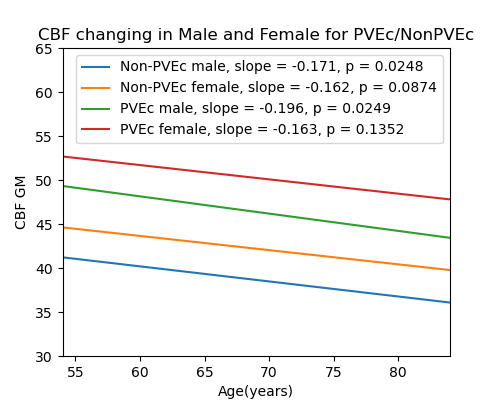

D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\vol_results


In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.plot(x_sample, pred_Y['vol_nonpvc_male'], label = 'Non-PVEc male'+ ', slope = '+ str(round(vol_models['vol_nonpvc_male'].params['x1'],3))  +', p = ' + str(round(vol_models['vol_nonpvc_male'].pvalues['x1'], 4)))
ax.plot(x_sample, pred_Y['vol_nonpvc_female'], label = 'Non-PVEc female'+ ', slope = '+ str(round(vol_models['vol_nonpvc_female'].params['x1'],3))  +', p = ' + str(round(vol_models['vol_nonpvc_female'].pvalues['x1'], 4)))
ax.plot(x_sample, pred_Y['vol_pvc_male'], label = 'PVEc male'+ ', slope = '+ str(round(vol_models['vol_pvc_male'].params['x1'],3))  +', p = ' + str(round(vol_models['vol_pvc_male'].pvalues['x1'], 4)))
ax.plot(x_sample, pred_Y['vol_pvc_female'], label = 'PVEc female'+ ', slope = '+ str(round(vol_models['vol_pvc_female'].params['x1'],3))  +', p = ' + str(round(vol_models['vol_pvc_female'].pvalues['x1'], 4)))

#ax.scatter(X['vol_nonpvc_female'][0], Y['vol_nonpvc_female'])
#plt.scatter(vol_nonpvc_X[:,0], vol_nonpvc_Y, s=10)
ax.legend(loc=1)
ax.set_xlabel('Age(years)')
ax.set_ylabel('CBF GM')
plt.xlim([54,84])
plt.ylim([30,65])
plt.title('CBF changing in Male and Female for PVEc/NonPVEc')
plt.show()
print(vol_work_dir)
plt.savefig(os.path.join(vol_work_dir, 'vol_Male&Female.jpg'))

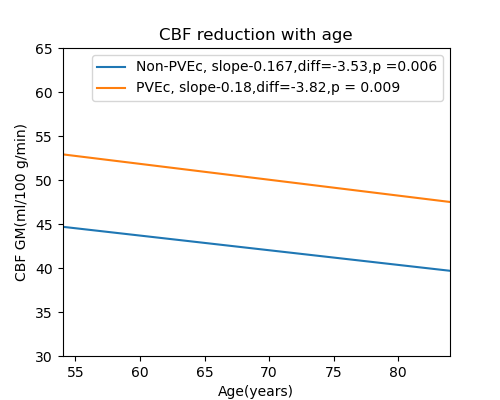

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(x_sample, pred_Y['vol_nonpvc'], label = 'Non-PVEc, slope'+str(round(vol_models['vol_nonpvc'].params['x1'],3))+ ',diff=' +str(round(vol_models['vol_nonpvc'].params['x2'],2))+',p =' + str(round(vol_models['vol_nonpvc'].pvalues['x1'],3)))
ax.plot(x_sample, pred_Y['vol_pvc'], label = 'PVEc, slope'+ str(round(vol_models['vol_pvc'].params['x1'],3)) + ',diff=' + str(round(vol_models['vol_pvc'].params['x2'],2)) +',p = ' + str(round(vol_models['vol_pvc'].pvalues['x1'], 3)))


ax.legend(loc=1)
ax.set_xlabel('Age(years)')
ax.set_ylabel('CBF GM(ml/100 g/min)')
plt.xlim([54,84])
plt.ylim([30,65])
plt.title('CBF reduction with age')
plt.show()
plt.savefig(os.path.join(vol_work_dir, 'vol_Male_and_female.jpg'))

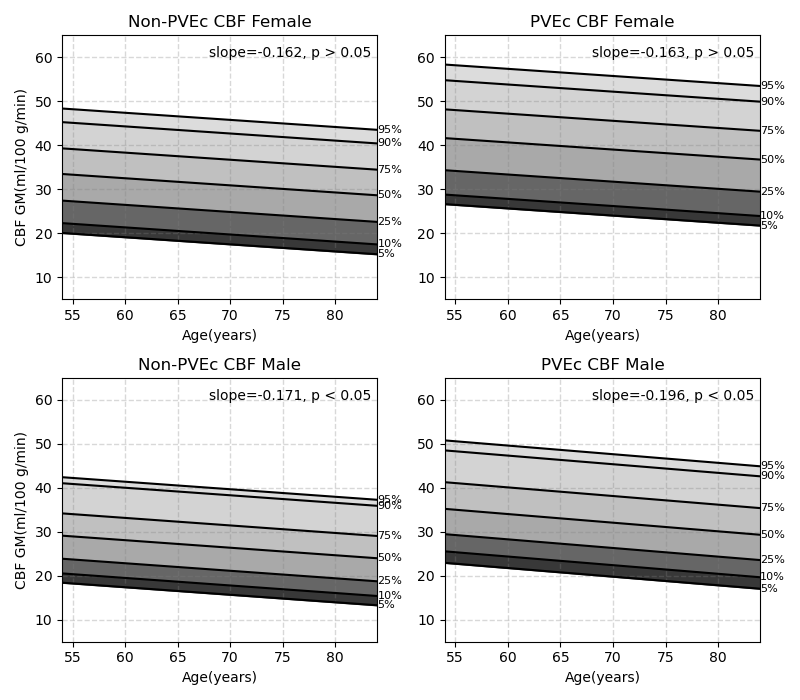

In [12]:
example_dfs = [vol_nonpvc_female, vol_nonpvc_male,vol_pvc_female, vol_pvc_male]
names = ["vol_nonpvc_female", "vol_nonpvc_male", "vol_pvc_female", "vol_pvc_male"]
gms = ["gm_voxel_nonpvc", "gm_voxel_nonpvc", "gm_voxel_pvc", "gm_voxel_pvc"]
titles = ["Non-PVEc CBF Female", "Non-PVEc CBF Male", "PVEc CBF Female", "PVEc CBF Male"]
texts= ['slope=-0.162, p > 0.05', 'slope=-0.171, p < 0.05','slope=-0.163, p > 0.05','slope=-0.196, p < 0.05',]

#fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
fig, axs = plt.subplots(2, 2, figsize=(8, 7))


for i in range(4):
    x = i%2
    y = int(i//2)
    #print('x=',x,'y=',y)
    #plt.subplots(1, 4)
    example_df = example_dfs[i]
    model_name = names[i]#'vol_nonpvc_male'
    gm_name = gms[i]#'gm_voxel_nonpvc'
    Q3 = np.quantile(example_df[gm_name], 0.75)
    Q1 = np.quantile(example_df[gm_name], 0.95)
    Q2 = np.quantile(example_df[gm_name], 0.90)
    Q4 = np.quantile(example_df[gm_name], 0.50)
    Q5 = np.quantile(example_df[gm_name], 0.25)
    Q6 = np.quantile(example_df[gm_name], 0.10)
    Q7 = np.quantile(example_df[gm_name], 0.05)
    IQR = Q3 - Q1
    #print(Q1, Q2, Q3, IQR)

    Q1_Y = []
    Q2_Y = []
    Q3_Y = []
    Q4_Y = []
    Q5_Y = []
    Q6_Y = []
    Q7_Y = []
    for x_ in x_sample:
        #y.extend(model[key].coef_[0]*x+model[key].predict([[0, sex]]))
        Q1_Y.append(vol_models[model_name].params['x1']*x_+Q1)
        Q2_Y.append(vol_models[model_name].params['x1']*x_+Q2)
        Q3_Y.append(vol_models[model_name].params['x1']*x_+Q3)
        Q4_Y.append(vol_models[model_name].params['x1']*x_+Q4)
        Q5_Y.append(vol_models[model_name].params['x1']*x_+Q5)
        Q6_Y.append(vol_models[model_name].params['x1']*x_+Q6)
        Q7_Y.append(vol_models[model_name].params['x1']*x_+Q7)

    #fig, ax = plt.subplots(1, 1, figsize=(5,4))
    axs[x][y].plot(x_sample, Q1_Y, label = '95%', color='black')
    axs[x][y].plot(x_sample, Q2_Y, label = '90%', color='black')
    axs[x][y].plot(x_sample, Q3_Y, label = '75%', color='black')
    axs[x][y].plot(x_sample, Q4_Y, label = '50%', color='black')
    axs[x][y].plot(x_sample, Q5_Y, label = '25%', color='black')
    axs[x][y].plot(x_sample, Q6_Y, label = '10%', color='black')
    axs[x][y].plot(x_sample, Q7_Y, label = '5%', color='black')

    axs[x][y].annotate("95%", xy=(84, Q1_Y[-1]),va='center', ha='left', fontsize=8)
    axs[x][y].annotate("90%", xy=(84, Q2_Y[-1]),va='center', ha='left', fontsize=8)
    axs[x][y].annotate("75%", xy=(84, Q3_Y[-1]),va='center', ha='left', fontsize=8)
    axs[x][y].annotate("50%", xy=(84, Q4_Y[-1]),va='center', ha='left', fontsize=8)
    axs[x][y].annotate("25%", xy=(84, Q5_Y[-1]),va='center', ha='left', fontsize=8)
    axs[x][y].annotate("10%", xy=(84, Q6_Y[-1]),va='center', ha='left', fontsize=8)
    axs[x][y].annotate("5%", xy=(84, Q7_Y[-1]),va='center', ha='left', fontsize=8)
    #plot(x_sample, Q7_Y, label = '5%', color='black')
    
    axs[x][y].text(68,60, texts[i])

    ax.legend(loc=1)
    axs[x][y].set_xlabel('Age(years)')
    if y == 0:
        axs[x][y].set_ylabel('CBF GM(ml/100 g/min)')
    axs[x][y].set_xlim([54, 84])
    axs[x][y].set_ylim([5, 65])
    axs[x][y].set_title(titles[i])
    #axs[i].text(1, 10, 'An example comment', fontsize=12)
    
    #plt.show()
    #plt.savefig(os.path.join(vol_work_dir, 'vol_Female.jpg'))


    axs[x][y].grid(color='gray', linestyle='--', linewidth=1, alpha=0.3)
    #plt.xaxis('tight')

    axs[x][y].fill_between(x_sample, Q1_Y, Q2_Y, color='gainsboro')
    axs[x][y].fill_between(x_sample, Q2_Y, Q3_Y, color='lightgray')
    axs[x][y].fill_between(x_sample, Q3_Y, Q4_Y, color='silver')
    axs[x][y].fill_between(x_sample, Q4_Y, Q5_Y, color='darkgray')
    axs[x][y].fill_between(x_sample, Q5_Y, Q6_Y, color='#666666')
    axs[x][y].fill_between(x_sample, Q6_Y, Q7_Y, color='#383838')
    #ax.fill_between(x_sample, Q6_Y, Q7_Y, color='g')
    #plt.show()
fig.tight_layout()
plt.savefig(os.path.join(vol_work_dir, 'vol_stats_by_pve_sex.jpg'))

### Hypothesis test

In [43]:
surf_models['surf_weighted_Dex_pvc']

{'surf_weighted_Dex_pvc': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2477f53a1d0>,
 'surf_weighted_Dex_nonpvc': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2470148d2d0>}

In [50]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm

#model1 = vol_models['vol_nonpvc']
#model2 = surf_models['surf_weighted_Dex_nonpvc']

#model1 = vol_models['vol_pvc']
#model2 = surf_models['surf_weighted_Dex_pvc']

#model1 = vol_models['vol_pvc']
#model2 = vol_models['vol_nonpvc']

model1 = surf_models['surf_weighted_Dex_nonpvc']
model2 = surf_models['surf_weighted_Dex_pvc']

beta1 = model1.params[1]
se1 = model1.bse[1]

beta2 = model2.params[1]
se2 = model2.bse[1]

print(beta1, beta2, se1, se2)



# Compute difference in slopes and pooled SE
delta_beta = beta1 - beta2
pooled_se = np.sqrt(se1**2 + se2**2)

# Compute z-value
z = delta_beta / pooled_se

# Compute p-value
p_value = 2 * (1 - norm.cdf(np.abs(z)))

print(f"Z-value: {z:.4f}")
print(f"P-value: {p_value:.4f}")

# If p-value is less than 0.05, the slopes are significantly different
if p_value < 0.05:
    print("The slopes are significantly different.")
else:
    print("The slopes are not significantly different.")


-0.22133378352438932 -0.05179371804904166 0.035792092068285514 0.06819473103991604
Z-value: -2.2013
P-value: 0.0277
The slopes are significantly different.


### Normative reference values

In [198]:

for model_name in ['vol_nonpvc', 'vol_pvc']:
    print('------------------', model_name)
    for sex in ['male', 'female']:
        print('------------------', sex)
        #example_df = vol_pvc_male
        mname = model_name
        if model_name == 'vol_nonpvc':
            gm_name = 'gm_voxel_nonpvc'
            if sex == 'female':
                example_df = vol_nonpvc_female
                mname = model_name+'_female'
            else:
                example_df = vol_nonpvc_male
                mname = model_name+'_male'
                
        if model_name == 'vol_pvc':
            example_df = vol_pvc
            gm_name = 'gm_voxel_pvc'
            if sex == 'female':
                example_df = vol_pvc_female
                mmname = model_name+'_female'
            else:
                example_df = vol_pvc_male
                mname = model_name+'_male'
        Q = []
        Q_Y = []
        print(model_name)
        percent = [0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, ][::-1]
        for i in range(len(percent)):
            Q.append(np.quantile(example_df[gm_name], percent[i]))
        #print(Q)

        for i in range(len(percent)):
            temp = []
            for x in x_sample:
                temp.append(vol_models[model_name].params['x1']*x+Q[i])
            Q_Y.append(temp)
        Q_Y = np.array(Q_Y)
        #print(Q_Y)
        df = pd.DataFrame(Q_Y, columns = x_sample.astype('int'))
        df.to_csv(os.path.join(vol_work_dir, model_name+'_'+sex+'_table.csv'))
        print(df)

------------------ vol_nonpvc
------------------ male
vol_nonpvc
          54         59         64         69         74         79        84
0  42.655851  41.822273  40.988694  40.155116  39.321537  38.487959  37.65438
1  41.285351  40.451773  39.618194  38.784616  37.951037  37.117459  36.28388
2  34.427351  33.593773  32.760194  31.926616  31.093037  30.259459  29.42588
3  29.362351  28.528773  27.695194  26.861616  26.028037  25.194459  24.36088
4  24.119851  23.286273  22.452694  21.619116  20.785537  19.951959  19.11838
5  20.779351  19.945773  19.112194  18.278616  17.445037  16.611459  15.77788
6  18.673851  17.840273  17.006694  16.173116  15.339537  14.505959  13.67238
------------------ female
vol_nonpvc
          54         59         64         69         74         79        84
0  48.083351  47.249773  46.416194  45.582616  44.749037  43.915459  43.08188
1  44.987351  44.153773  43.320194  42.486616  41.653037  40.819459  39.98588
2  39.022351  38.188773  37.355194  36.5

In [199]:

for is_pvc in ['pvc', 'nonpvc']:
    work_dir = os.path.join(vol_save_path, is_pvc) #nonpvc_dex_surf_data_path
    #rois = {}
    reg_dict = []
    for sub in os.listdir(work_dir):
        #print(sub)
        try:
            data = pd.read_csv(os.path.join(work_dir, sub))
            #print(data)
            data = data.dropna(how='any')
            X = np.column_stack((data['age'], data['sex']))
            Y = data['gm']
            x = sm.add_constant(X)
            reg = sm.OLS(Y, x).fit()
            reg_dict.append({'roi':sub[:-4], 'a':reg.params[1], 'b':reg.params[2], 'const':reg.params[0], 'gm': np.mean(Y), 'std': np.std(Y), 'p':reg.pvalues[1]})
        except Exception as e:
            print(e)



    #save results to local
    #temp_save_path = os.path.join(vol_save_path, weight)
    #Path(os.path.join(temp_save_path, 'left')).mkdir(parents=True, exist_ok=True)
    reg_df = pd.DataFrame.from_dict(reg_dict)
    #reg_df.sort_values(by='a', ascending=True, inplace=True)
    reg_df.round(4).to_csv(os.path.join(vol_save_path, is_pvc +'_rois_reg.csv'))
        


C:\Users\swjtu\AppData\Local\Temp\ipykernel_18184\2121576969.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reg_dict.append({'roi':sub[:-4], 'a':reg.params[1], 'b':reg.params[2], 'const':reg.params[0], 'gm': np.mean(Y), 'std': np.std(Y), 'p':reg.pvalues[1]})
C:\Users\swjtu\AppData\Local\Temp\ipykernel_18184\2121576969.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reg_dict.append({'roi':sub[:-4], 'a':reg.params[1], 'b':reg.params[2], 'const':reg.params[0], 'gm': np.mean(Y), 'std': np.std(Y), 'p':reg.pvalues[1]})
C:\Users\swjtu\AppData\Local\Temp\ipykernel_18184\2121576969.py:15: FutureWarning: Series.__ge

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity


C:\Users\swjtu\AppData\Local\Temp\ipykernel_18184\2121576969.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reg_dict.append({'roi':sub[:-4], 'a':reg.params[1], 'b':reg.params[2], 'const':reg.params[0], 'gm': np.mean(Y), 'std': np.std(Y), 'p':reg.pvalues[1]})
C:\Users\swjtu\AppData\Local\Temp\ipykernel_18184\2121576969.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reg_dict.append({'roi':sub[:-4], 'a':reg.params[1], 'b':reg.params[2], 'const':reg.params[0], 'gm': np.mean(Y), 'std': np.std(Y), 'p':reg.pvalues[1]})
C:\Users\swjtu\AppData\Local\Temp\ipykernel_18184\2121576969.py:15: FutureWarning: Series.__ge

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
'utf-8' codec can't decode byte 0xff in position 0: invalid start byte


C:\Users\swjtu\AppData\Local\Temp\ipykernel_18184\2121576969.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reg_dict.append({'roi':sub[:-4], 'a':reg.params[1], 'b':reg.params[2], 'const':reg.params[0], 'gm': np.mean(Y), 'std': np.std(Y), 'p':reg.pvalues[1]})
C:\Users\swjtu\AppData\Local\Temp\ipykernel_18184\2121576969.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reg_dict.append({'roi':sub[:-4], 'a':reg.params[1], 'b':reg.params[2], 'const':reg.params[0], 'gm': np.mean(Y), 'std': np.std(Y), 'p':reg.pvalues[1]})
C:\Users\swjtu\AppData\Local\Temp\ipykernel_18184\2121576969.py:15: FutureWarning: Series.__ge

# Surface-based results

In [13]:
surf_data_path = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\oxasl_surf'
pvc_dex_surf_data_path =  os.path.join(surf_data_path, 'weighted', 'Dex',  'pvc')
nonpvc_dex_surf_data_path =  os.path.join(surf_data_path, 'weighted', 'Dex',  'nonpvc')
surf_save_path = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\surf_results_final'


## GM for each cortical parcellation over the whole group 

In [15]:
for weight in ['weighted', 'no_weighted']:
    for atlas in ['Dex', 'DK']:
        for is_pvc in ['pvc', 'nonpvc']:
            work_dir = os.path.join(surf_data_path, weight, atlas, is_pvc) #nonpvc_dex_surf_data_path
            left_hemi_roi = {}
            right_hemi_roi = {}
            
            example_name = 'sub-1267031'
            if is_pvc == 'pvc': example_name += '_pvc_perfusion_'
            else: example_name += '_nonpvc_perfusion_'
            if atlas == 'Dex': example_name += 'dex'
            else: example_name += 'dk'
            left_example_name = example_name + '_left_stats.csv'#'sub-1267031_pvc_perfusion_dex_left_stats.csv'
            right_example_name = example_name + '_right_stats.csv'#'sub-1267031_pvc_perfusion_dex_right_stats.csv'
            
            
            #get the name of all parcels from a subject by hemisphere
            rois_left = pd.read_csv(os.path.join(work_dir, left_example_name)).to_numpy()
            for roi in rois_left:
                roi_name = roi[0]
                left_hemi_roi[roi_name] = []

            rois_right = pd.read_csv(os.path.join(work_dir, right_example_name)).to_numpy()
            for roi in rois_right:
                roi_name = roi[0]
                right_hemi_roi[roi_name] = []


            for sub in os.listdir(work_dir):
                sub_id = int(sub[4:11])
                if sub_id in subjects_exclusion_list:continue
                sex=(tilda_df.loc[tilda_df['MRN']==sub_id]['sex_W3']).to_numpy()[0]
                age=(tilda_df.loc[tilda_df['MRN']==sub_id]['age_W3']).to_numpy()[0]
                #print(sex, age, sub)
                try:
                    df = pd.read_csv(os.path.join(work_dir, sub)).to_numpy()
                    if 'left' in sub:
                        for row in df:
                            #print(row)
                            roi_name = row[0]
                            roi_gm = row[1]
                            #print(roi_name)
                            if roi_gm < 10: continue
                            left_hemi_roi[roi_name].append({'subject': sub_id, 'gm':roi_gm, 'sex':sex, 'age':age})

                    elif 'right' in sub:
                        for row in df:
                            #print(row)
                            roi_name = row[0]
                            roi_gm = row[1]
                            #print(row[0], row[1])
                            if roi_gm < 10: continue
                            right_hemi_roi[roi_name].append({'subject': sub_id, 'gm':roi_gm, 'sex':sex, 'age':age})
                except:
                    print('data loss')
                    #print(right_hemi_roi)



            #save results to local
            temp_save_path = os.path.join(surf_save_path, weight, atlas, is_pvc)
            Path(os.path.join(temp_save_path, 'left')).mkdir(parents=True, exist_ok=True)
            Path(os.path.join(temp_save_path, 'right')).mkdir(parents=True, exist_ok=True)
            for roi in left_hemi_roi:
                try:
                    df = pd.DataFrame.from_dict(left_hemi_roi[roi])
                    df.round(3).to_csv(os.path.join(temp_save_path, 'left', roi+'.csv'))
                except Exception as e:
                    print(e)


            for roi in right_hemi_roi:
                try:
                    df = pd.DataFrame.from_dict(right_hemi_roi[roi])
                    df.round(3).to_csv(os.path.join(temp_save_path, 'right', roi+'.csv'))
                except Exception as e:
                    print(e)


[Errno 22] Invalid argument: 'D:\\onedrive\\OneDrive - The University of Nottingham\\TILDA\\analysis_results\\region_analysis\\surf_results_final\\weighted\\Dex\\pvc\\left\\???.csv'
[Errno 22] Invalid argument: 'D:\\onedrive\\OneDrive - The University of Nottingham\\TILDA\\analysis_results\\region_analysis\\surf_results_final\\weighted\\Dex\\pvc\\right\\???.csv'
[Errno 22] Invalid argument: 'D:\\onedrive\\OneDrive - The University of Nottingham\\TILDA\\analysis_results\\region_analysis\\surf_results_final\\weighted\\Dex\\nonpvc\\left\\???.csv'
[Errno 22] Invalid argument: 'D:\\onedrive\\OneDrive - The University of Nottingham\\TILDA\\analysis_results\\region_analysis\\surf_results_final\\weighted\\Dex\\nonpvc\\right\\???.csv'
[Errno 22] Invalid argument: 'D:\\onedrive\\OneDrive - The University of Nottingham\\TILDA\\analysis_results\\region_analysis\\surf_results_final\\weighted\\DK\\pvc\\left\\???.csv'
[Errno 22] Invalid argument: 'D:\\onedrive\\OneDrive - The University of Nottingham

## Regressions for each parcel

In [16]:
for weight in ['weighted', 'no_weighted']:
    for atlas in ['Dex', 'DK']:
        for is_pvc in ['pvc', 'nonpvc']:
            work_dir = os.path.join(surf_save_path, weight, atlas, is_pvc) 
            
            left_dict = []
            left_male_dict = []
            left_female_dict = []

            right_dict = []
            right_male_dict = []
            right_female_dict = []
            bi_dict = []
            
            for hemi in ['left', 'right']:
                cur_dir = os.path.join(work_dir, hemi)
                print('Woking on ', weight, atlas, is_pvc, 'hemisphere: '  + hemi)
                for stat_file in os.listdir(cur_dir):
                    #print(stat_file)
                    try:
                        data = pd.read_csv(os.path.join(cur_dir, stat_file))
                        #print(cur_dir, stat_file)
                        data['sex'].replace(2,0, inplace=True)
                        X = np.column_stack((data['age'], data['sex']))
                        Y = data['gm']
                        x = sm.add_constant(X)
                        reg = sm.OLS(Y, x).fit()

                        male_data = data[data['sex'] == 1]
                        male_X = np.column_stack((male_data['age'], male_data['sex']))
                        male_Y = male_data['gm']
                        male_x = sm.add_constant(male_X)
                        reg_male = sm.OLS(male_Y, male_x).fit()

                        female_data = data[data['sex'] == 0]
                        female_X = np.column_stack((female_data['age'], female_data['sex']))
                        female_Y = female_data['gm']
                        female_x = sm.add_constant(female_X)
                        reg_female = sm.OLS(female_Y, female_x).fit()
                        #reg = LinearRegression().fit(X, Y)
                        #print(stat_file, reg.coef_)
                        pred = reg.predict(x)[0]
                        pred_female = reg_female.predict(female_x)[0]
                        pred_male = reg_male.predict(male_x)[0]

                        if hemi == 'left':
                            if stat_file[0] == 'b':
                                left_dict.append({'roi':stat_file[2:-5], 'a':reg.params['x1'], 'b':reg.params['x2'], 'gm': np.mean(Y), 'std': np.std(Y), 'pred':pred, 'p':reg.pvalues['x1']})
                                left_female_dict.append({'roi':stat_file[2:-5], 'a':reg_female.params['x1'], 'gm': np.mean(female_Y), 'std': np.std(female_Y), 'p':reg_female.pvalues['x1']})
                                left_male_dict.append({'roi':stat_file[2:-5], 'a':reg_male.params['x1'], 'gm': np.mean(male_Y), 'std': np.std(male_Y), 'p':reg_male.pvalues['x1']})

                            else:
                                left_dict.append({'roi':stat_file[0:-4], 'a':reg.params['x1'], 'b':reg.params['x2'], 'gm': np.mean(Y), 'std': np.std(Y),  'pred':pred, 'p':reg.pvalues['x1']})
                                left_female_dict.append({'roi':stat_file[0:-4], 'a':reg_female.params['x1'], 'gm': np.mean(female_Y), 'std': np.std(female_Y), 'p':reg_female.pvalues['x1']})
                                left_male_dict.append({'roi':stat_file[0:-4], 'a':reg_male.params['x1'], 'gm': np.mean(male_Y), 'std': np.std(male_Y), 'p':reg_male.pvalues['x1']})

                        else:
                            if stat_file[0] == 'b':
                                right_dict.append({'roi':stat_file[2:-5], 'a':reg.params['x1'], 'b':reg.params['x2'], 'gm': np.mean(Y), 'std': np.std(Y),  'pred':pred, 'p':reg.pvalues['x1']})
                                right_female_dict.append({'roi':stat_file[2:-5], 'a':reg_female.params['x1'], 'gm': np.mean(female_Y), 'std': np.std(female_Y), 'p':reg_female.pvalues['x1']})
                                right_male_dict.append({'roi':stat_file[2:-5], 'a':reg_male.params['x1'], 'gm': np.mean(male_Y), 'std': np.std(male_Y), 'p':reg_male.pvalues['x1']})

                            else:
                                right_dict.append({'roi':stat_file[0:-4], 'a':reg.params['x1'], 'b':reg.params['x2'], 'gm': np.mean(Y), 'std': np.std(Y),  'pred':pred, 'p':reg.pvalues['x1']})
                                right_female_dict.append({'roi':stat_file[0:-4], 'a':reg_female.params['x1'], 'gm': np.mean(female_Y), 'std': np.std(female_Y), 'p':reg_female.pvalues['x1']})
                                right_male_dict.append({'roi':stat_file[0:-4], 'a':reg_male.params['x1'], 'gm': np.mean(male_Y), 'std': np.std(male_Y), 'p':reg_male.pvalues['x1']})
                    except Exception as e:
                        print(cur_dir, stat_file, e)

            
            
            #print('Done')
            left_hemi_df = pd.DataFrame.from_dict(left_dict)
            right_hemi_df = pd.DataFrame.from_dict(right_dict)
            left_female_df = pd.DataFrame.from_dict(left_female_dict)
            right_female_df = pd.DataFrame.from_dict(right_female_dict)
            left_male_df = pd.DataFrame.from_dict(left_male_dict)
            right_male_df = pd.DataFrame.from_dict(right_male_dict)
            
            left_hemi_df.sort_values(by='roi', ascending=True, inplace=True)
            left_hemi_df.round(4).to_csv(os.path.join(work_dir, weight+ '_'+ atlas + '_' + is_pvc +'_left_hemi_rois_reg.csv'))
            right_hemi_df.sort_values(by='roi', ascending=True, inplace=True)
            right_hemi_df.round(4).to_csv(os.path.join(work_dir, weight+ '_'+ atlas + '_' + is_pvc +'_right_hemi_rois_reg.csv'))
            
            left_male_df.sort_values(by='roi', ascending=True, inplace=True)
            left_male_df.round(4).to_csv(os.path.join(work_dir, weight+ '_'+ atlas + '_' + is_pvc +'_left_male_rois_reg.csv'))
            right_male_df.sort_values(by='roi', ascending=True, inplace=True)
            right_male_df.round(4).to_csv(os.path.join(work_dir, weight+ '_'+ atlas + '_' + is_pvc +'_right_male_rois_reg.csv'))
            
            left_female_df.sort_values(by='roi', ascending=True, inplace=True)
            left_female_df.round(4).to_csv(os.path.join(work_dir, weight+ '_'+ atlas + '_' + is_pvc +'_left_female_rois_reg.csv'))
            right_female_df.sort_values(by='roi', ascending=True, inplace=True)
            right_female_df.round(4).to_csv(os.path.join(work_dir, weight+ '_'+ atlas + '_' + is_pvc +'_right_female_rois_reg.csv'))

Woking on  weighted Dex pvc hemisphere: left
D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\surf_results_final\weighted\Dex\pvc\left L_corpuscallosum.csv 'sex'
Woking on  weighted Dex pvc hemisphere: right
D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\surf_results_final\weighted\Dex\pvc\right R_corpuscallosum.csv 'sex'
Woking on  weighted Dex nonpvc hemisphere: left
D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\surf_results_final\weighted\Dex\nonpvc\left L_corpuscallosum.csv 'sex'
Woking on  weighted Dex nonpvc hemisphere: right
D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\surf_results_final\weighted\Dex\nonpvc\right R_corpuscallosum.csv 'sex'
Woking on  weighted DK pvc hemisphere: left
D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\surf_results_final\weighted\DK\pv

# bilateral brain

In [17]:
for weight in ['weighted', 'no_weighted']:
    for atlas in ['Dex', 'DK']:
        for is_pvc in ['pvc', 'nonpvc']:
            work_dir = os.path.join(surf_save_path, weight, atlas, is_pvc) #nonpvc_dex_surf_data_path
            #ork_dir = os.path.join(work_path, 'region_analysis', 'surf_results', 'Dex', 'pvc')
            left_dict = []
            left_male_dict = []
            left_female_dict = []

            right_dict = []
            right_male_dict = []
            right_female_dict = []
            
            bi_dict = {}
            bi_female_dict = {}
            bi_male_dict = {}
            
            reg_dict = []
            reg_female_dict = []
            reg_male_dict = []
            roi_names = set()
            
            for hemi in ['left', 'right']:
                cur_dir = os.path.join(work_dir, hemi)
                #print('Woking on ', weight, atlas, is_pvc, 'hemisphere: '  + hemi)
                
                for stat_file in os.listdir(cur_dir):
                    #print(stat_file)
                    try:
                        if stat_file == 'Left_Hemi.csv' or stat_file == 'Right_Hemi.csv':
                            roi = stat_file[:-4]
                            roi_names.add(roi)
                        else:
                            roi = stat_file[2:-4]
                            roi_names.add(roi)
                            
                        data = pd.read_csv(os.path.join(cur_dir, stat_file))
                        data['sex'].replace(2,0, inplace=True)
                        
                        X = np.column_stack((data['age'], data['sex']))
                        Y = data['gm']
                    
                        male_data = data[data['sex'] == 1]
                        male_X = np.column_stack((male_data['age'], male_data['sex']))
                        male_Y = male_data['gm']

                        female_data = data[data['sex'] == 0]
                        female_X = np.column_stack((female_data['age'], female_data['sex']))
                        female_Y = female_data['gm']
                        
                        
                        bi_dict[roi] = (X, Y)
                        bi_female_dict[roi] = (female_X, female_Y)
                        bi_male_dict[roi] = (male_X, male_Y)
                    
                    except Exception as e:
                        #print('Excception: ',cur_dir, stat_file, e)
                        pass
 
            
    
            bi_left = bi_dict['Left_Hemi']
            bi_right = bi_dict['Right_Hemi']
            X_data = np.vstack((bi_left[0], bi_right[0]))
            Y_data = np.concatenate((bi_left[1].to_numpy(), bi_right[1].to_numpy()))
            print(type(bi_left[1]))
            #print(bi_left[1].shape)
            print(X_data.shape, Y_data.shape)
            #print(bi_right[1].shape)
            
            x = sm.add_constant(X_data)
            #Y = bi_data[1]
            reg = sm.OLS(Y_data, x).fit()
            reg_dict.append({'roi':'Bilateral', 'a':reg.params[0], 'b':reg.params[1], 'gm': np.mean(Y), 'std': np.std(Y), 'pred':pred, 'p_x1':reg.pvalues[0], 'p_x2':reg.pvalues[1]},)
            #left_dict.append({'roi':stat_file[2:-5], 'a':reg.params['x1'], 'b':reg.params['x2'], 'gm': np.mean(Y), 'std': np.std(Y), 'pred':pred, 'p':reg.pvalues['x1']})
            #print(reg_dict)
            for roi in roi_names:
                if roi == 'Left_Hemi' or roi == 'Right_Hemi':
                    continue
                left_pre = 'L_'
                right_pre = 'R_'
                left_roi = left_pre+roi
                right_roi = right_pre+roi
                #if left_roi in bi_dict.keys() and right_roi in bi_dict.keys()
                #bi_X = np.stack(bi_dict[left_roi][0], bi_dict[right_roi][0])
                #bi_Y = np.concatenate((bi_left[1].to_numpy(), bi_right[1].to_numpy()))
                x = sm.add_constant(X_data)
                reg = sm.OLS(Y_data, x).fit()
                reg_dict.append({'roi':'Bilateral', 'a':reg.params[0], 'b':reg.params[1], 'gm': np.mean(Y), 'std': np.std(Y), 'pred':pred, 'p_x1':reg.pvalues[0], 'p_x2':reg.pvalues[1]},)
                
                break
                    
            
            

<class 'pandas.core.series.Series'>
(846, 2) (846,)
<class 'pandas.core.series.Series'>
(845, 2) (845,)
<class 'pandas.core.series.Series'>
(846, 2) (846,)
<class 'pandas.core.series.Series'>
(845, 2) (845,)
<class 'pandas.core.series.Series'>
(846, 2) (846,)
<class 'pandas.core.series.Series'>
(845, 2) (845,)
<class 'pandas.core.series.Series'>
(846, 2) (846,)
<class 'pandas.core.series.Series'>
(845, 2) (845,)


In [19]:
surf_models = {}

for weight in ['weighted', 'no_weighted']:
    for atlas in ['Dex', 'DK']:
        for is_pvc in ['pvc', 'nonpvc']:
            work_dir = os.path.join(surf_save_path, weight, atlas, is_pvc) 
            left_dict = []
            left_male_dict = []
            left_female_dict = []

            right_dict = []
            right_male_dict = []
            right_female_dict = []
            
            global_brain_X = {}
            global_brain_Y = {}
            #_brain = []
            global_dict = []
            
            for hemi in ['left', 'right']:
                cur_dir = os.path.join(work_dir, hemi)
                print('Woking on ', weight, atlas, is_pvc, 'hemisphere: '  + hemi)
                for stat_file in os.listdir(cur_dir):
                    #print(stat_file)
                    try:
                        data = pd.read_csv(os.path.join(cur_dir, stat_file))
                        data['sex'].replace(2,0, inplace=True)

                        if stat_file[0] == 'b':
                            roi = stat_file[4:-5]

                        else:
                            roi = stat_file[2:-4]
                        if '&' in roi:
                            roi = roi.replace('&', '_')
                            #print(roi)
                        if roi == 'ght_Hemi' or roi == 'ft_Hemi':
                            roi = 'total'
                        #print(roi)
                        #global_brain_X[roi]
                        X = np.column_stack((data['age'], data['sex']))
                        Y = data['gm']
                        if roi in global_brain_X.keys():
                            #print(global_brain_X[roi].shape)
                            #print(X.shape)
                            #print([global_brain_X[roi], X])
                            global_brain_X[roi] = np.append(global_brain_X[roi], X, axis=0)
                            global_brain_Y[roi] = np.append(global_brain_Y[roi], Y, axis=0)
                        else:
                            global_brain_X[roi] = X
                            global_brain_Y[roi] = Y
                    except:
                        pass
                    
                    
            for roi in global_brain_X.keys():
                X = global_brain_X[roi]
                Y = global_brain_Y[roi]
                #print(X.shape, Y.shape)
                x = sm.add_constant(X)
                reg = sm.OLS(Y, x).fit()

                pred = reg.predict(x)[0]
                pred_female = reg_female.predict(female_x)
                pred_male = reg_male.predict(male_x)
                    
                if stat_file[0] == 'b':
                    global_dict.append({'roi':roi, 'a':reg.params[1], 'b':reg.params[2], 'gm': np.mean(Y), 'std': np.std(Y), 'pred':pred, 'p0':reg.pvalues[0], 'p':reg.pvalues[1]})

                else:
                    #print({'roi':roi, 'a':reg.params['x1'], 'b':reg.params['x2'], 'gm': np.mean(Y), 'std': np.std(Y),  'pred':pred, 'p':reg.pvalues['x1']})
                    global_dict.append({'roi':roi, 'a':reg.params[1], 'b':reg.params[2], 'gm': np.mean(Y), 'std': np.std(Y),  'pred':pred, 'p0':reg.pvalues[0], 'p':reg.pvalues[1]})
                
                if weight == 'weighted' and atlas == 'Dex' and roi == 'total':
                    #print(is_pvc)
                    #print(X)
                    t = np.sort(Y)
                    #print(t[0:2], t[-4:] )
                    #print(Y.mean(), Y.min(), Y.max(), Y.std())
                    #print(reg.summary())

                    surf_models['surf_'+weight+'_'+atlas+'_'+is_pvc] = reg
            #print('Done')
            global_df = pd.DataFrame.from_dict(global_dict)
            
            
            #global_df.sort_values(by='roi', ascending=True, inplace=True)
            global_df['a'] = global_df['a'].round(2)
            global_df['b'] = global_df['b'].round(2)
            global_df['gm'] = global_df['gm'].round(2)
            global_df['p'] = global_df['p'].round(4)
            global_df['p0'] = global_df['p0'].round(4)
            global_df.to_csv(os.path.join(work_dir, weight+ '_'+ atlas + '_' + is_pvc +'_global_rois_reg.csv'))

Woking on  weighted Dex pvc hemisphere: left
Woking on  weighted Dex pvc hemisphere: right
Woking on  weighted Dex nonpvc hemisphere: left
Woking on  weighted Dex nonpvc hemisphere: right
Woking on  weighted DK pvc hemisphere: left
Woking on  weighted DK pvc hemisphere: right
Woking on  weighted DK nonpvc hemisphere: left
Woking on  weighted DK nonpvc hemisphere: right
Woking on  no_weighted Dex pvc hemisphere: left
Woking on  no_weighted Dex pvc hemisphere: right
Woking on  no_weighted Dex nonpvc hemisphere: left
Woking on  no_weighted Dex nonpvc hemisphere: right
Woking on  no_weighted DK pvc hemisphere: left
Woking on  no_weighted DK pvc hemisphere: right
Woking on  no_weighted DK nonpvc hemisphere: left
Woking on  no_weighted DK nonpvc hemisphere: right


## Combination of stats for male and female

In [20]:
atlas = 'Dex'
weight = 'weighted'
ipvc = 'nonpvc'

In [21]:

nonpvc_right_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_nonpvc_right_hemi_rois_reg.csv'))
nonpvc_right_male_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_nonpvc_right_male_rois_reg.csv'))
nonpvc_right_female_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_nonpvc_right_female_rois_reg.csv'))

nonpvc_left_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_nonpvc_left_hemi_rois_reg.csv'))
nonpvc_left_male_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_nonpvc_left_male_rois_reg.csv'))
nonpvc_left_female_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_nonpvc_left_female_rois_reg.csv'))


In [22]:
left_df_by_sex = pd.merge(nonpvc_left_male_hemi[['roi', 'a', 'gm', 'p']], nonpvc_left_female_hemi[['roi', 'a', 'gm', 'p']], how = 'outer', on = 'roi')
left_df_by_sex.rename(columns = {'a_x': 'male_slope', 'gm_x':'male_gm', 'a_y': 'female_slope', 'gm_y':'female_gm', 'a':'mean_slope', 'b':'diff'}, inplace=True)

left_df_by_sex = left_df_by_sex.round(3)   
left_df_by_sex.sort_values(by='roi', ascending=True, inplace=True)
#print(left_df_by_sex)
left_df_by_sex.to_csv(os.path.join(surf_save_path, weight, atlas, ipvc, 'left_hemi_rois_by_sex.csv'))

In [23]:
right_df_by_sex = pd.merge(nonpvc_right_male_hemi[['roi', 'a', 'gm', 'p']], nonpvc_right_female_hemi[['roi', 'a', 'gm', 'p']], how = 'outer', on = 'roi')
right_df_by_sex.rename(columns = {'a_x': 'male_slope', 'gm_x':'male_gm', 'a_y': 'female_slope', 'gm_y':'female_gm', 'a':'mean_slope', 'b':'diff'}, inplace=True)

right_df_by_sex = right_df_by_sex.round(3)
right_df_by_sex.sort_values(by='roi', ascending=True, inplace=True)
right_df_by_sex.to_csv(os.path.join(surf_save_path, weight, atlas, ipvc, 'right_hemi_rois_by_sex.csv'))

In [24]:
nonpvc_total = pd.merge(left_df_by_sex, right_df_by_sex, how = 'outer', on = 'roi')
nonpvc_total.to_csv(os.path.join(surf_save_path, weight, atlas, ipvc, 'left_right_nonpvc_total.csv'))

In [25]:
atlas = 'Dex'
weight = 'weighted'#'no_weighted'
ipvc = 'pvc'

In [26]:

nonpvc_right_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_pvc_right_hemi_rois_reg.csv'))
nonpvc_right_male_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_pvc_right_male_rois_reg.csv'))
nonpvc_right_female_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_pvc_right_female_rois_reg.csv'))

nonpvc_left_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_pvc_left_hemi_rois_reg.csv'))
nonpvc_left_male_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_pvc_left_male_rois_reg.csv'))
nonpvc_left_female_hemi = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, weight+'_'+atlas+'_pvc_left_female_rois_reg.csv'))


In [27]:
left_df_by_sex = pd.merge(nonpvc_left_male_hemi[['roi', 'a', 'gm', 'p']], nonpvc_left_female_hemi[['roi', 'a', 'gm', 'p']], how = 'outer', on = 'roi')
left_df_by_sex.rename(columns = {'a_x': 'male_slope', 'gm_x':'male_gm', 'a_y': 'female_slope', 'gm_y':'female_gm', 'a':'mean_slope', 'b':'diff'}, inplace=True)

left_df_by_sex = left_df_by_sex.round(3)
left_df_by_sex.sort_values(by='roi', ascending=True, inplace=True)
left_df_by_sex.round(3).to_csv(os.path.join(surf_save_path, weight, atlas, ipvc, 'left_hemi_rois_by_sex.csv'))

right_df_by_sex = pd.merge(nonpvc_right_male_hemi[['roi', 'a', 'gm', 'p']], nonpvc_right_female_hemi[['roi', 'a', 'gm', 'p']], how = 'outer', on = 'roi')
right_df_by_sex.rename(columns = {'a_x': 'male_slope', 'gm_x':'male_gm', 'a_y': 'female_slope', 'gm_y':'female_gm', 'a':'mean_slope', 'b':'diff'}, inplace=True)

right_df_by_sex = right_df_by_sex.round(3)
right_df_by_sex.sort_values(by='roi', ascending=True, inplace=True)
right_df_by_sex.round(3).to_csv(os.path.join(surf_save_path, weight, atlas, ipvc, 'right_hemi_rois_by_sex.csv'))

In [28]:
pvc_total = pd.merge(left_df_by_sex, right_df_by_sex, how = 'outer', on = 'roi')
pvc_total.to_csv(os.path.join(surf_save_path, weight, atlas, ipvc, 'left_right_pvc_total.csv'))

## draw normative table

In [29]:
def get_surf_stats(atlas, pvc, hemi,filename):
    work_dir=r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\surf_results_final\weighted'
    stat_file = os.path.join(work_dir,atlas, pvc, hemi, filename)
    df = pd.read_csv(stat_file)
    df = df[[ 'subject', 'age', 'sex','gm']]
    df['sex'].replace(2,0, inplace=True)
    data = df
    return data

In [30]:
weighted_dex_nonpvc_hemi_df = get_surf_stats('Dex','nonpvc','right', 'Right_Hemi.csv')
weighted_dex_pvc_left_df = get_surf_stats('Dex','nonpvc','left', 'Left_Hemi.csv')

In [31]:
weighted_dex_nonpvc_right_df = get_surf_stats('Dex','nonpvc','right', 'Right_Hemi.csv')
weighted_dex_nonpvc_left_df = get_surf_stats('Dex','nonpvc','left', 'Left_Hemi.csv')
weighted_dex_pvc_right_df = get_surf_stats('Dex','pvc','right', 'Right_Hemi.csv')
weighted_dex_pvc_left_df = get_surf_stats('Dex','pvc','left', 'Left_Hemi.csv')

weighted_dex_nonpvc_df = get_surf_stats('Dex','pvc','right', 'Right_Hemi.csv')

surf_nonpvc_left_X = np.column_stack((weighted_dex_nonpvc_left_df['age'], weighted_dex_nonpvc_left_df['sex']))
surf_nonpvc_left_Y = weighted_dex_nonpvc_left_df['gm']
surf_nonpvc_right_X = np.column_stack((weighted_dex_nonpvc_right_df['age'], weighted_dex_nonpvc_right_df['sex']))
surf_nonpvc_right_Y = weighted_dex_nonpvc_right_df['gm']

surf_pvc_left_X = np.column_stack((weighted_dex_pvc_left_df['age'], weighted_dex_pvc_left_df['sex']))
surf_pvc_left_Y = weighted_dex_pvc_left_df['gm']
surf_pvc_right_X = np.column_stack((weighted_dex_pvc_right_df['age'], weighted_dex_pvc_right_df['sex']))
surf_pvc_right_Y = weighted_dex_pvc_right_df['gm']


X = {
     'surf_nonpvc_left':surf_nonpvc_left_X,
     'surf_pvc_left':surf_pvc_left_X,
     'surf_nonpvc_right':surf_nonpvc_right_X,
     'surf_pvc_right':surf_pvc_right_X,
    }

Y = {
     'surf_nonpvc_left':surf_nonpvc_left_Y,
     'surf_pvc_left':surf_pvc_left_Y,
     'surf_nonpvc_right':surf_nonpvc_right_Y,
     'surf_pvc_right':surf_pvc_right_Y,
    }

model = {}
for (key, val) in X.items():
    x = sm.add_constant(X[key])
    
    model[key] = sm.OLS(Y[key], x).fit()
    print(key)
    print(model[key].summary())
    print('--------------------')

    



surf_nonpvc_left
                            OLS Regression Results                            
Dep. Variable:                     gm   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     23.35
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           2.42e-10
Time:                        10:35:26   Log-Likelihood:                -1410.8
No. Observations:                 422   AIC:                             2828.
Df Residuals:                     419   BIC:                             2840.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.2688      3.402   

In [42]:
surf_models

{'surf_weighted_Dex_pvc': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2477f53a1d0>,
 'surf_weighted_Dex_nonpvc': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2470148d2d0>}

In [32]:
# set age checkpoints
x_sample = np.linspace(54,84, 5)
pred_Y = {}
for (key, val) in model.items():
    print(key)
    sex = X[key][0][1]
    y = []
    #print(model[key].params['x1']*1, model[key].params['const'])
    for x in x_sample:
        #y.extend(model[key].coef_[0]*x+model[key].predict([[0, sex]]))
        y.append(model[key].params['x1']*x+model[key].params['const'])
    
    #print(y)
    pred_Y[key] = y

    

surf_nonpvc_left
surf_pvc_left
surf_nonpvc_right
surf_pvc_right


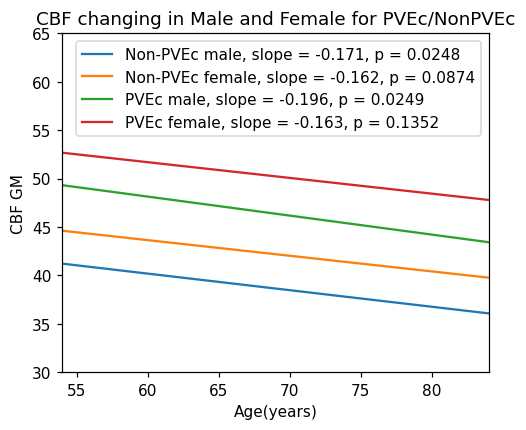

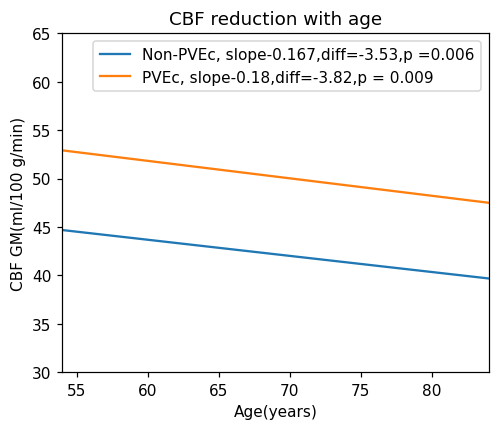

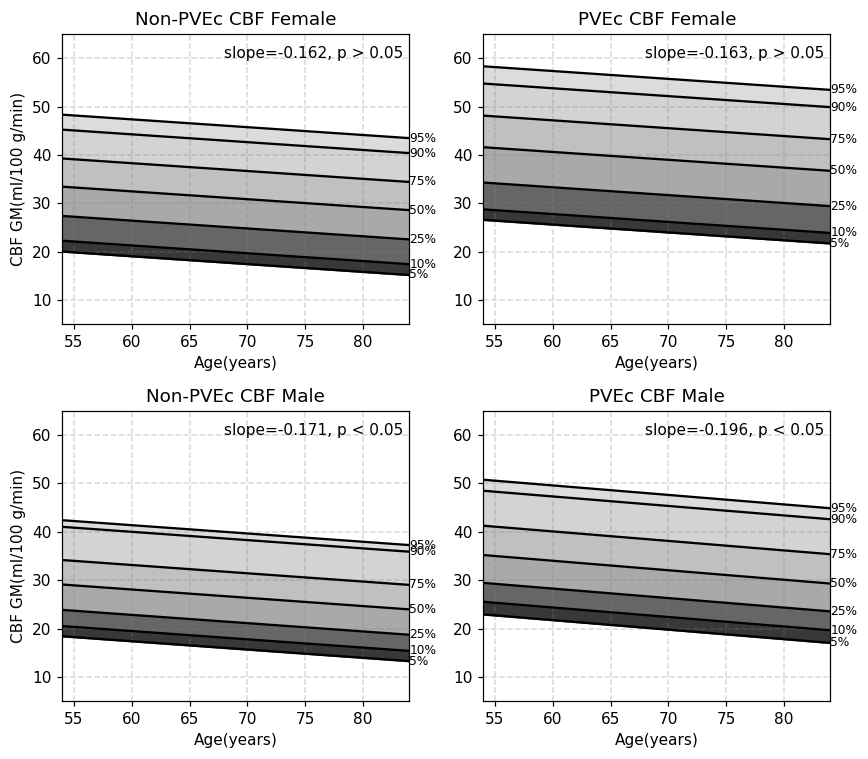

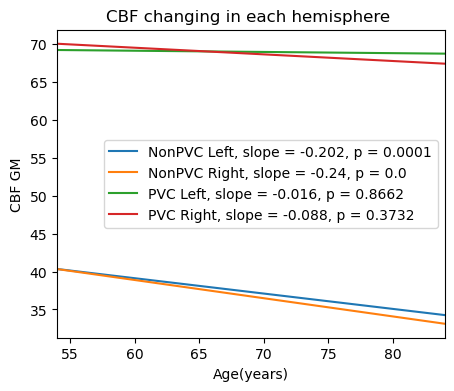

<Figure size 640x480 with 0 Axes>

In [34]:
%matplotlib inline

work_dir=r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\surf_results_final\weighted'
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(x_sample, pred_Y['surf_nonpvc_left'], label = 'NonPVC Left'+ ', slope = '+ str(round(model['surf_nonpvc_left'].params['x1'],3))  +', p = ' + str(round(model['surf_nonpvc_left'].pvalues['x1'], 4)))
ax.plot(x_sample, pred_Y['surf_nonpvc_right'], label = 'NonPVC Right'+ ', slope = '+ str(round(model['surf_nonpvc_right'].params['x1'],3))  +', p = ' + str(round(model['surf_nonpvc_right'].pvalues['x1'], 4)))
ax.plot(x_sample, pred_Y['surf_pvc_left'], label = 'PVC Left'+ ', slope = '+ str(round(model['surf_pvc_left'].params['x1'],3))  +', p = ' + str(round(model['surf_pvc_left'].pvalues['x1'], 4)))
ax.plot(x_sample, pred_Y['surf_pvc_right'], label = 'PVC Right'+ ', slope = '+ str(round(model['surf_pvc_right'].params['x1'],3))  +', p = ' + str(round(model['surf_pvc_right'].pvalues['x1'], 4)))
#plt.scatter(vol_nonpvc_X[:,0], vol_nonpvc_Y, s=10)
ax.legend(loc=0)
ax.set_xlabel('Age(years)')
ax.set_ylabel('CBF GM')
plt.xlim([54,84])
#plt.ylim([32,52])
plt.title('CBF changing in each hemisphere ')
plt.show()
plt.savefig(os.path.join(work_dir, 'surf_Male&Female.jpg'))

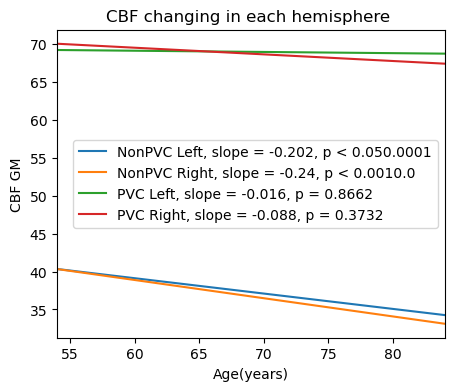

<Figure size 640x480 with 0 Axes>

In [35]:
%matplotlib inline

work_dir=r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results\region_analysis\surf_results_final\weighted'
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(x_sample, pred_Y['surf_nonpvc_left'], label = 'NonPVC Left'+ ', slope = '+ str(round(model['surf_nonpvc_left'].params['x1'],3))  +', p < 0.05' + str(round(model['surf_nonpvc_left'].pvalues['x1'], 4)))
ax.plot(x_sample, pred_Y['surf_nonpvc_right'], label = 'NonPVC Right'+ ', slope = '+ str(round(model['surf_nonpvc_right'].params['x1'],3))  +', p < 0.001' + str(round(model['surf_nonpvc_right'].pvalues['x1'], 4)))
ax.plot(x_sample, pred_Y['surf_pvc_left'], label = 'PVC Left'+ ', slope = '+ str(round(model['surf_pvc_left'].params['x1'],3))  +', p = ' + str(round(model['surf_pvc_left'].pvalues['x1'], 4)))
ax.plot(x_sample, pred_Y['surf_pvc_right'], label = 'PVC Right'+ ', slope = '+ str(round(model['surf_pvc_right'].params['x1'],3))  +', p = ' + str(round(model['surf_pvc_right'].pvalues['x1'], 4)))
#plt.scatter(vol_nonpvc_X[:,0], vol_nonpvc_Y, s=10)
ax.legend(loc=0)
ax.set_xlabel('Age(years)')
ax.set_ylabel('CBF GM')
plt.xlim([54,84])
#plt.ylim([32,52])
plt.title('CBF changing in each hemisphere ')
plt.show()
plt.savefig(os.path.join(work_dir, 'surf_Male&Female.jpg'))

In [37]:
atlas = 'Dex'
weight = 'weighted'
ipvc = 'nonpvc'
surf_dex_nonpvc = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, 'weighted_'+atlas+'_'+ipvc+'_global_rois_reg.csv'))
ipvc = 'pvc'
surf_dex_pvc = pd.read_csv(os.path.join(surf_save_path, weight, atlas, ipvc, 'weighted_'+atlas+'_'+ipvc+'_global_rois_reg.csv'))


In [39]:
pvc_nonpvc = pd.merge(surf_dex_nonpvc, surf_dex_pvc, how = 'outer', on = 'roi')
pvc_nonpvc = pvc_nonpvc[pvc_nonpvc['p_y'] <= 0.05]
pvc_nonpvc.to_csv(os.path.join(surf_save_path, weight,'pvc_nonpvc_comp_005.csv'))

In [40]:

example_dfs = [surf_dex_nonpvc, surf_dex_pvc]
for model_name in ['surf_weighted_Dex_nonpvc', 'surf_weighted_Dex_pvc']:
    #example_df = vol_pvc_male
    if model_name == 'surf_dex_nonpvc':
        example_df = surf_dex_nonpvc
        gm_name = 'gm'
    if model_name == 'surf_dex_pvc':
        example_df = surf_dex_pvc
        gm_name = 'gm'
    Q = []
    Q_Y = []
    percent = [0.05, 0.10, 0.25, 0.5, 0.75, 0.90, 0.95, ][::-1]
    for i in range(len(percent)):
        Q.append(np.quantile(example_df[gm_name], percent[i]))
    #print(Q)
    print(Q)
    for i in range(len(percent)):
        temp = []
        for x in x_sample:
            temp.append(surf_models[model_name].params[1]*x+Q[i])
        Q_Y.append(temp)
    Q_Y = np.array(Q_Y)
    #print(Q_Y)
    df = pd.DataFrame(Q_Y, columns = x_sample.astype('int'))
    print(df)

SyntaxError: invalid syntax (2185193034.py, line 16)

KeyError: 'surf_nonpvc'

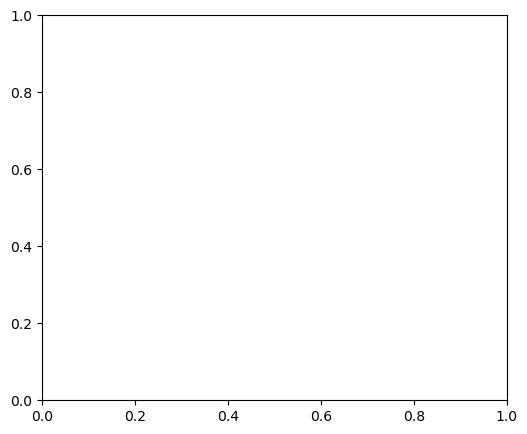

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))
#ax.plot(x_sample, pred_Y['vol_nonpvc_male'], label = 'Non-PVEc male, slope='+str(round(model['vol_nonpvc_male'].params['x1'],2))+',intercept='+str(round(model['vol_nonpvc_male'].params['const'],2)))
#ax.plot(x_sample, pred_Y['vol_nonpvc_female'], label = 'Non-PVEc female, slope'+str(round(model['vol_nonpvc_female'].params['x1'],2))+',intercept='+str(round(model['vol_nonpvc_female'].params['const'],2)))
#ax.plot(x_sample, pred_Y['vol_pvc_male'], label = 'PVEc male, slope'+str(round(model['vol_pvc_male'].params['x1'],2))+',intercept='+str(round(model['vol_pvc_male'].params['const'],2)))
#ax.plot(x_sample, pred_Y['vol_pvc_female'], label = 'PVEc female, slope'+str(round(model['vol_pvc_female'].params['x1'],2))+',intercept='+str(round(model['vol_pvc_female'].params['const'],2)))

ax.plot(x_sample, pred_Y['surf_nonpvc'], label = 'Non-PVEc, slope'+str(round(model['vol_nonpvc'].params['x1'],3))+ ',diff=' +str(round(model['vol_nonpvc'].params['x2'],2))+',p =' + str(round(model['vol_nonpvc'].pvalues['x1'],3)))
ax.plot(x_sample, pred_Y['surf_pvc'], label = 'PVEc, slope'+ str(round(model['vol_pvc'].params['x1'],3)) + ',diff=' + str(round(model['vol_pvc'].params['x2'],2)) +',p = ' + str(round(model['vol_pvc'].pvalues['x1'], 3)))

        
#ax.plot(x_sample, pred_Y['vol_nonpvc'], label = 'Non-PVEc: slope='+str(round(model['vol_nonpvc'].params['x1'],2))+', sex diff='+str(round(model['vol_nonpvc'].params['x2'],2)) +', p < 0.05')
#ax.plot(x_sample, pred_Y['vol_pvc'], label = 'PVEc: slope='+str(round(model['vol_pvc'].params['x1'],2))+', sex diff='+str(round(model['vol_pvc'].params['x2'],2))+', p < 0.01')

        
#plt.scatter(vol_nonpvc_X[:,0], vol_nonpvc_Y, s=10)
ax.legend(loc=1)
ax.set_xlabel('Age(years)')
ax.set_ylabel('CBF GM(ml/100 g/min)')
plt.xlim([52,85])
plt.ylim([35,55])
plt.title('CBF reduction with age')
plt.show()
plt.savefig(os.path.join(work_dir, 'surf_Male_and_female.jpg'))

43.48616 42.59534 41.87635 -1.609809999999996


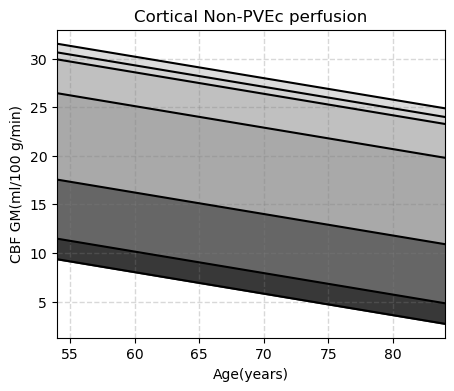

<Figure size 640x480 with 0 Axes>

In [142]:

example_df = surf_dex_nonpvc
model_name = 'surf_weighted_Dex_nonpvc'
gm_name = 'gm'
Q3 = np.quantile(example_df[gm_name], 0.75)
Q1 = np.quantile(example_df[gm_name], 0.95)
Q2 = np.quantile(example_df[gm_name], 0.90)
Q4 = np.quantile(example_df[gm_name], 0.50)
Q5 = np.quantile(example_df[gm_name], 0.25)
Q6 = np.quantile(example_df[gm_name], 0.10)
Q7 = np.quantile(example_df[gm_name], 0.05)
IQR = Q3 - Q1
print(Q1, Q2, Q3, IQR)
#print(model[model_name].predict(54))
#print(model[model_name].predict(84, 0))
#print(model[model_name].params['x1']*54+model[model_name].params['const'])
#print(model[model_name].params['x1']*84+model[model_name].params['const'])
#print(model[model_name].params['x1']*84+Q1)
#print(model[model_name].params['x1']*84+Q3)
#print(model[model_name].params['x1']*54+Q1)
#print(model[model_name].params['x1']*54+Q3)
#x_sample = np.linspace(50,90, 10)
Q1_Y = []
Q2_Y = []
Q3_Y = []
Q4_Y = []
Q5_Y = []
Q6_Y = []
Q7_Y = []
for x in x_sample:
        #y.extend(model[key].coef_[0]*x+model[key].predict([[0, sex]]))
    Q1_Y.append(surf_models[model_name].params[1]*x+Q1)
    Q2_Y.append(surf_models[model_name].params[1]*x+Q2)
    Q3_Y.append(surf_models[model_name].params[1]*x+Q3)
    Q4_Y.append(surf_models[model_name].params[1]*x+Q4)
    Q5_Y.append(surf_models[model_name].params[1]*x+Q5)
    Q6_Y.append(surf_models[model_name].params[1]*x+Q6)
    Q7_Y.append(surf_models[model_name].params[1]*x+Q7)
    
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(x_sample, Q1_Y, label = '95%', color='black')
ax.plot(x_sample, Q2_Y, label = '90%', color='black')
ax.plot(x_sample, Q3_Y, label = '75%', color='black')
ax.plot(x_sample, Q4_Y, label = '50%', color='black')
ax.plot(x_sample, Q5_Y, label = '25%', color='black')
ax.plot(x_sample, Q6_Y, label = '10%', color='black')
ax.plot(x_sample, Q7_Y, label = '5%', color='black')




#ax.legend(loc=1)
ax.set_xlabel('Age(years)')
ax.set_ylabel('CBF GM(ml/100 g/min)')
plt.xlim([54,84])
#plt.ylim([38,50])
plt.title('Cortical Non-PVEc perfusion')
#plt.show()
#plt.savefig(os.path.join(work_dir, 'vol_Female.jpg'))


ax.grid(color='gray', linestyle='--', linewidth=1, alpha=0.3)
#plt.xaxis('tight')

#ax.autoscale(enable=True, axis='x', tight=True)
#y90=female['GAMLSS_pred']+1.645*female['GAMLSS_sigma']
#y10=female['GAMLSS_pred']-1.645*female['GAMLSS_sigma']
#y95=female['GAMLSS_pred']+1.96*female['GAMLSS_sigma']
#y5=female['GAMLSS_pred']-1.96*female['GAMLSS_sigma']
#y75=female['GAMLSS_pred']+1.15*female['GAMLSS_sigma']
#y25=female['GAMLSS_pred']-1.15*female['GAMLSS_sigma']
#y50=female['GAMLSS_pred']
ax.fill_between(x_sample, Q1_Y, Q2_Y, color='gainsboro')
ax.fill_between(x_sample, Q2_Y, Q3_Y, color='lightgray')
ax.fill_between(x_sample, Q3_Y, Q4_Y, color='silver')
ax.fill_between(x_sample, Q4_Y, Q5_Y, color='darkgray')
ax.fill_between(x_sample, Q5_Y, Q6_Y, color='#666666')
ax.fill_between(x_sample, Q6_Y, Q7_Y, color='#383838')
#ax.fill_between(x_sample, Q6_Y, Q7_Y, color='g')
plt.show()
fig.tight_layout()
plt.savefig(os.path.join(work_dir, 'surf_weighted_Dex_nonpvc.jpg'))

86.39931 83.047 78.42375 -7.9755600000000015


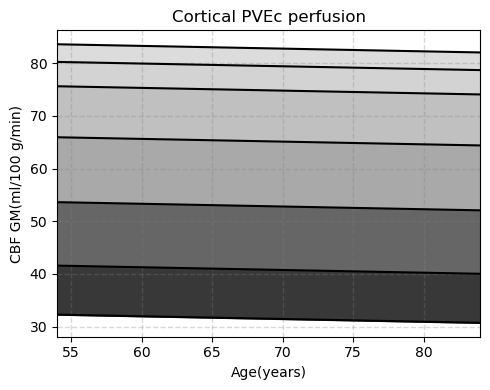

<Figure size 640x480 with 0 Axes>

In [143]:

example_df = surf_dex_pvc
model_name = 'surf_weighted_Dex_pvc'
gm_name = 'gm'
Q3 = np.quantile(example_df[gm_name], 0.75)
Q1 = np.quantile(example_df[gm_name], 0.95)
Q2 = np.quantile(example_df[gm_name], 0.90)
Q4 = np.quantile(example_df[gm_name], 0.50)
Q5 = np.quantile(example_df[gm_name], 0.25)
Q6 = np.quantile(example_df[gm_name], 0.10)
Q7 = np.quantile(example_df[gm_name], 0.05)
IQR = Q3 - Q1
print(Q1, Q2, Q3, IQR)
#print(model[model_name].predict(54))
#print(model[model_name].predict(84, 0))
#print(model[model_name].params['x1']*54+model[model_name].params['const'])
#print(model[model_name].params['x1']*84+model[model_name].params['const'])
#print(model[model_name].params['x1']*84+Q1)
#print(model[model_name].params['x1']*84+Q3)
#print(model[model_name].params['x1']*54+Q1)
#print(model[model_name].params['x1']*54+Q3)
#x_sample = np.linspace(50,90, 10)
Q1_Y = []
Q2_Y = []
Q3_Y = []
Q4_Y = []
Q5_Y = []
Q6_Y = []
Q7_Y = []
for x in x_sample:
        #y.extend(model[key].coef_[0]*x+model[key].predict([[0, sex]]))
    Q1_Y.append(surf_models[model_name].params[1]*x+Q1)
    Q2_Y.append(surf_models[model_name].params[1]*x+Q2)
    Q3_Y.append(surf_models[model_name].params[1]*x+Q3)
    Q4_Y.append(surf_models[model_name].params[1]*x+Q4)
    Q5_Y.append(surf_models[model_name].params[1]*x+Q5)
    Q6_Y.append(surf_models[model_name].params[1]*x+Q6)
    Q7_Y.append(surf_models[model_name].params[1]*x+Q7)
    
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.plot(x_sample, Q1_Y, label = '95%', color='black')
ax.plot(x_sample, Q2_Y, label = '90%', color='black')
ax.plot(x_sample, Q3_Y, label = '75%', color='black')
ax.plot(x_sample, Q4_Y, label = '50%', color='black')
ax.plot(x_sample, Q5_Y, label = '25%', color='black')
ax.plot(x_sample, Q6_Y, label = '10%', color='black')
ax.plot(x_sample, Q7_Y, label = '5%', color='black')




#ax.legend(loc=1)
ax.set_xlabel('Age(years)')
ax.set_ylabel('CBF GM(ml/100 g/min)')
plt.xlim([54,84])
#plt.ylim([38,50])
plt.title('Cortical PVEc perfusion')


ax.grid(color='gray', linestyle='--', linewidth=1, alpha=0.3)

ax.fill_between(x_sample, Q1_Y, Q2_Y, color='gainsboro')
ax.fill_between(x_sample, Q2_Y, Q3_Y, color='lightgray')
ax.fill_between(x_sample, Q3_Y, Q4_Y, color='silver')
ax.fill_between(x_sample, Q4_Y, Q5_Y, color='darkgray')
ax.fill_between(x_sample, Q5_Y, Q6_Y, color='#666666')
ax.fill_between(x_sample, Q6_Y, Q7_Y, color='#383838')
#ax.fill_between(x_sample, Q6_Y, Q7_Y, color='g')
fig.tight_layout()
plt.show()
plt.savefig(os.path.join(work_dir, 'surf_weighted_Dex_pvc.jpg'))

In [ ]:
#compute the regression for each roi from each hemishpere
work_path = r'D:\onedrive\OneDrive - The University of Nottingham\TILDA\analysis_results'
work_dir = os.path.join(work_path, 'region_analysis', 'surf_results_final','weighted', 'Dex', 'pvc')
left_dict = []
right_dict = []

left_dict_female = []
left_dict_male = []
right_dict_female = []
right_dict_male = []

for hemi in ['left', 'right']:
    cur_dir = os.path.join(work_dir, hemi)
    print('Woking on hemisphere: '  + hemi)
    for stat_file in os.listdir(cur_dir):
        try:
            data = pd.read_csv(os.path.join(cur_dir, stat_file))
            X = np.column_stack((data['age'], data['sex']))
            Y = data['gm']
            #reg = LinearRegression().fit(X, Y)
            x = sm.add_constant(X)
            reg = sm.OLS(male_Y, male_x).fit()
            #print(stat_file, reg.coef_)
            pred = reg.predict(X)
            if hemi == 'left':
                if stat_file[0] == 'b':
                    left_dict.append({'roi':stat_file[2:-5], 'a':reg.coef_[0], 'b':reg.coef_[1], 'gm': np.mean(Y), 'std': np.std(Y), 'X':X, 'Y':Y, 'pred':pred})
                else:
                    left_dict.append({'roi':stat_file[0:-4], 'a':reg.coef_[0], 'b':reg.coef_[1], 'gm': np.mean(Y), 'std': np.std(Y), 'X':X, 'Y':Y, 'pred':pred})
            else:
                if stat_file[0] == 'b':
                    right_dict.append({'roi':stat_file[2:-5], 'a':reg.coef_[0], 'b':reg.coef_[1], 'gm': np.mean(Y), 'std': np.std(Y), 'X':X, 'Y':Y, 'pred':pred})
                else:
                    right_dict.append({'roi':stat_file[0:-4], 'a':reg.coef_[0], 'b':reg.coef_[1], 'gm': np.mean(Y), 'std': np.std(Y), 'X':X, 'Y':Y, 'pred':pred})
        except:
            pass
            
        
print('Done')
            